In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
stores = pd.read_csv('./stores.csv')
features = pd.read_csv('./features.csv')
sample_submission = pd.read_csv('./sampleSubmission.csv')

In [3]:
train[:-5]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421560,45,98,2012-08-24,415.40,False
421561,45,98,2012-08-31,346.04,False
421562,45,98,2012-09-07,352.44,True
421563,45,98,2012-09-14,605.96,False


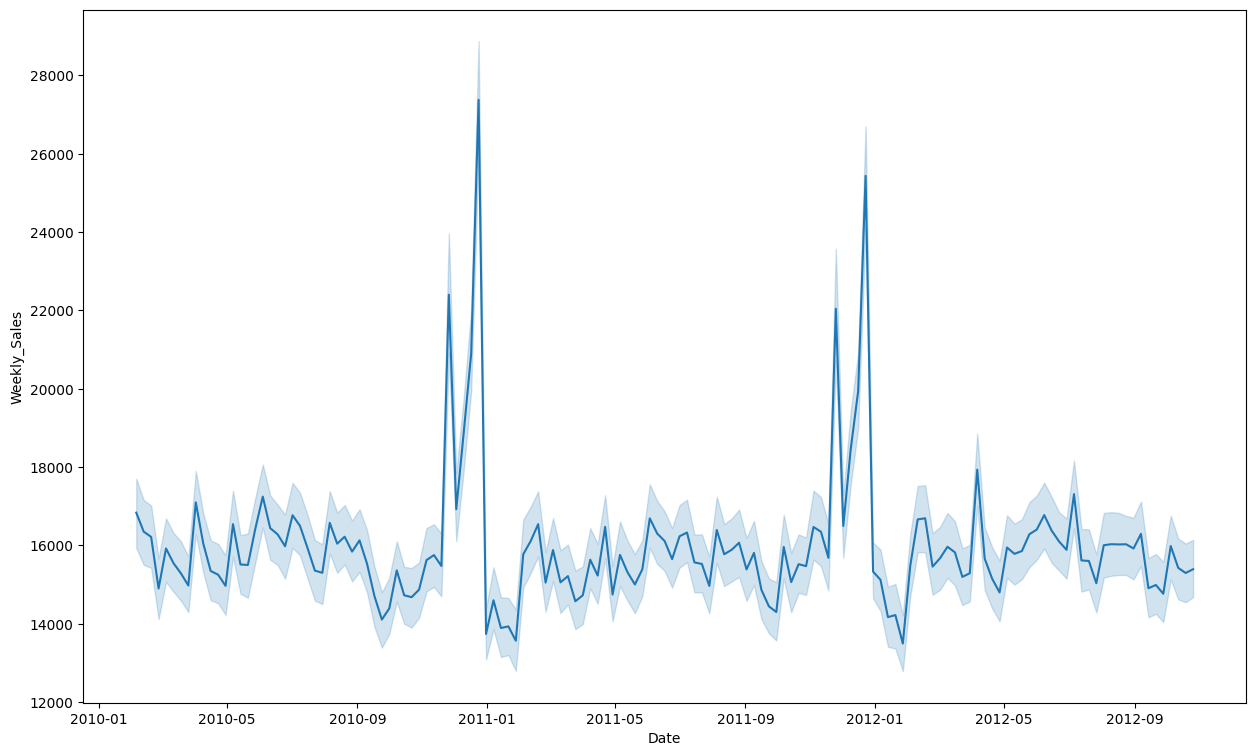

In [4]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

plt.figure(figsize=(15,9))
sns.lineplot(data = train, x=train['Date'], y=train['Weekly_Sales'])
plt.show();

In [5]:
train['Year'] = train['Date'].dt.year
test['Year'] = test['Date'].dt.year

train['Month'] = train['Date'].dt.month
test['Month'] = test['Date'].dt.month

train['DayOfWeek']  = train['Date'].dt.day_of_week
test['DayOfWeek'] = test['Date'].dt.day_of_week

In [6]:
train_agg = train.groupby('Date')['Weekly_Sales'].sum().reset_index()
train_agg

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


In [7]:
test_agg = test.groupby('Date').first().reset_index()
test_dates = test_agg[['Date']]

In [8]:
def apply_sin_cos_transformation(df, col_name, period):
    df[f'{col_name}_sin'] = np.sin(df[col_name]) * (2*np.pi/period)
    df[f'{col_name}_cos'] = np.cos(df[col_name]) * (2*np.pi/period)
    return df

def feature_engineer(df):
    new_df = df.copy()
    new_df['Month'] = new_df['Date'].dt.month
    new_df['DayOfWeek'] = new_df['Date'].dt.day_of_week
    new_df['year'] = new_df['Date'].dt.year
    new_df = apply_sin_cos_transformation(new_df, 'Month', 12)
    new_df = apply_sin_cos_transformation(new_df, 'DayOfWeek', 12)
    new_df = new_df.drop(columns=['Date', 'Month', 'DayOfWeek'])
    return new_df
    

In [9]:
y_train = train_agg['Weekly_Sales']
X_train = train_agg.drop(['Weekly_Sales'], axis=1)
X_test = test_dates.copy()
X_train = feature_engineer(X_train)
X_test = feature_engineer(X_test)

In [10]:
def train_and_predict(X_train, y_train, X_test):
    pred_lst = []
    n_splits = 3
    kf = GroupKFold(n_splits=n_splits)
    scores = []
    train_scores = np.zeros(len(X_train))

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train,groups=X_train.year)):
        model = LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=50, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.iloc[train_idx]), columns=X_train.columns)
        X_val_scaled = pd.DataFrame(scaler.transform(X_train.iloc[val_idx]), columns=X_train.columns)
        X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        model.fit(X_train_scaled, y_train.iloc[train_idx])
        pred_lst.append(model.predict(X_test_scaled))
        train_scores[val_idx] = model.predict(X_val_scaled)
        sc = model.score(X_val_scaled, y_train.iloc[val_idx])
        scores.append(sc)
        print(f'fold: {fold} score: {sc}')
    mean_score = np.mean(scores)
    print('mean_score:', mean_score)
    return pred_lst, train_scores

preds_lst, train_scores = train_and_predict(X_train, y_train, X_test)
train_pred = pd.DataFrame()
train_pred['Date'] = train_agg['Date']
train_pred['Weekly_Sales'] = train_scores

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29
[LightGBM] [Info] Number of data points in the train set: 91, number of used features: 3
[LightGBM] [Info] Start training from score 47132076.923077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [11]:
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns=['2010', '2011', '2012'])
preds_df['Weekly_Sales'] = preds_df.mean(axis=1)
test_dates['Weekly_Sales'] = preds_df['Weekly_Sales']

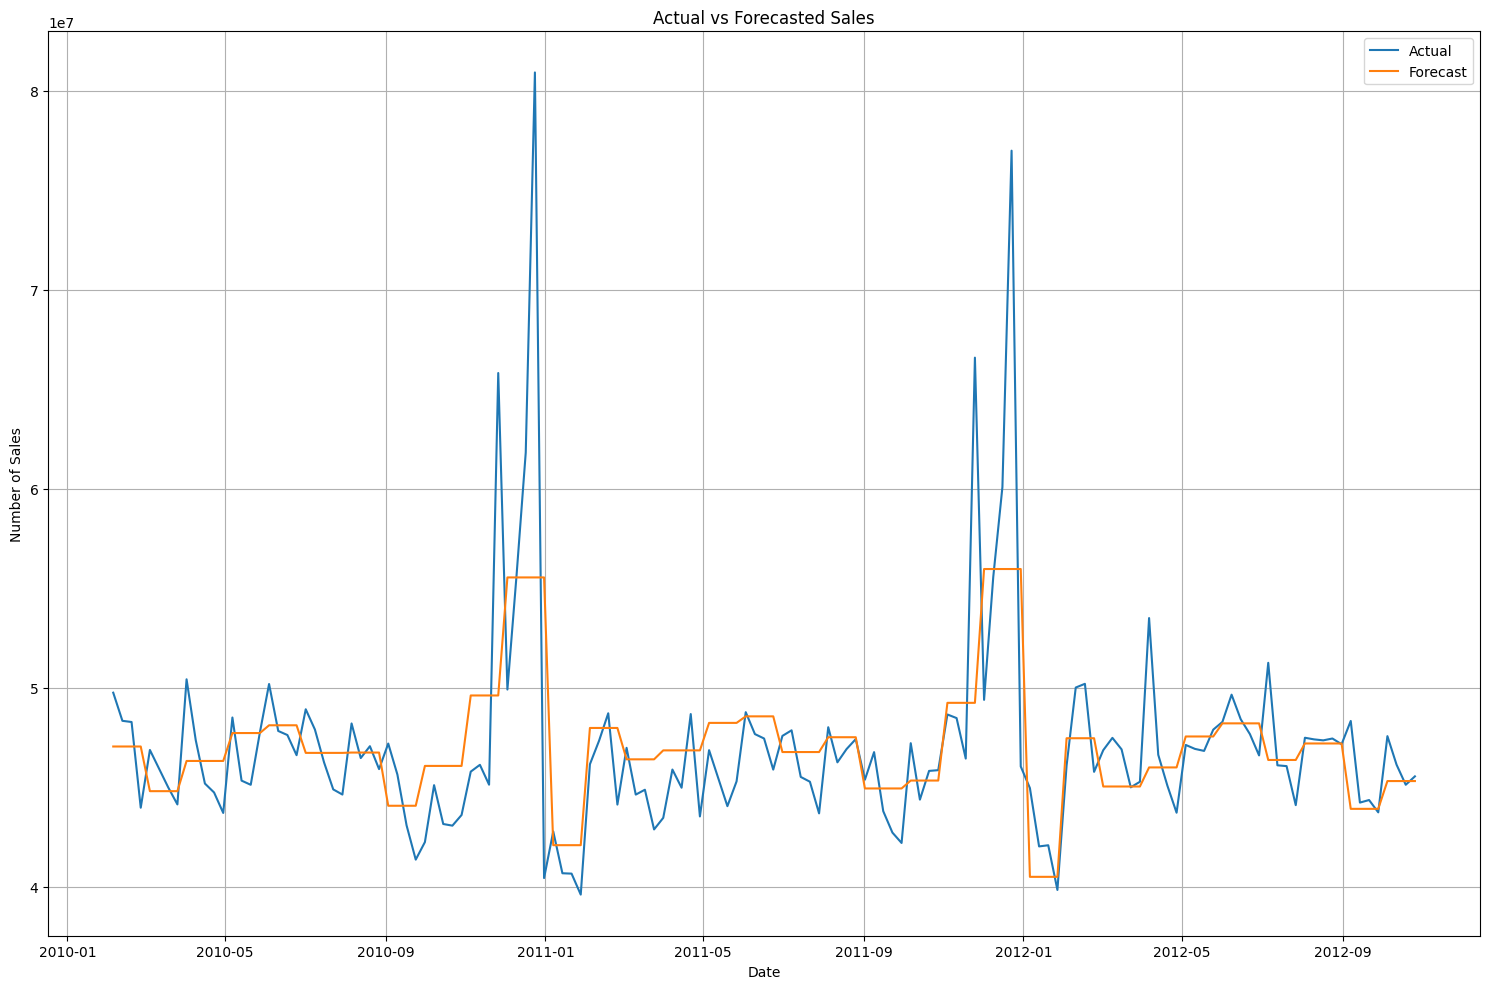

In [12]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Weekly_Sales", label='Actual')
sns.lineplot(data=train_pred, x='Date', y='Weekly_Sales', label="Forecast")
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Actual vs Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

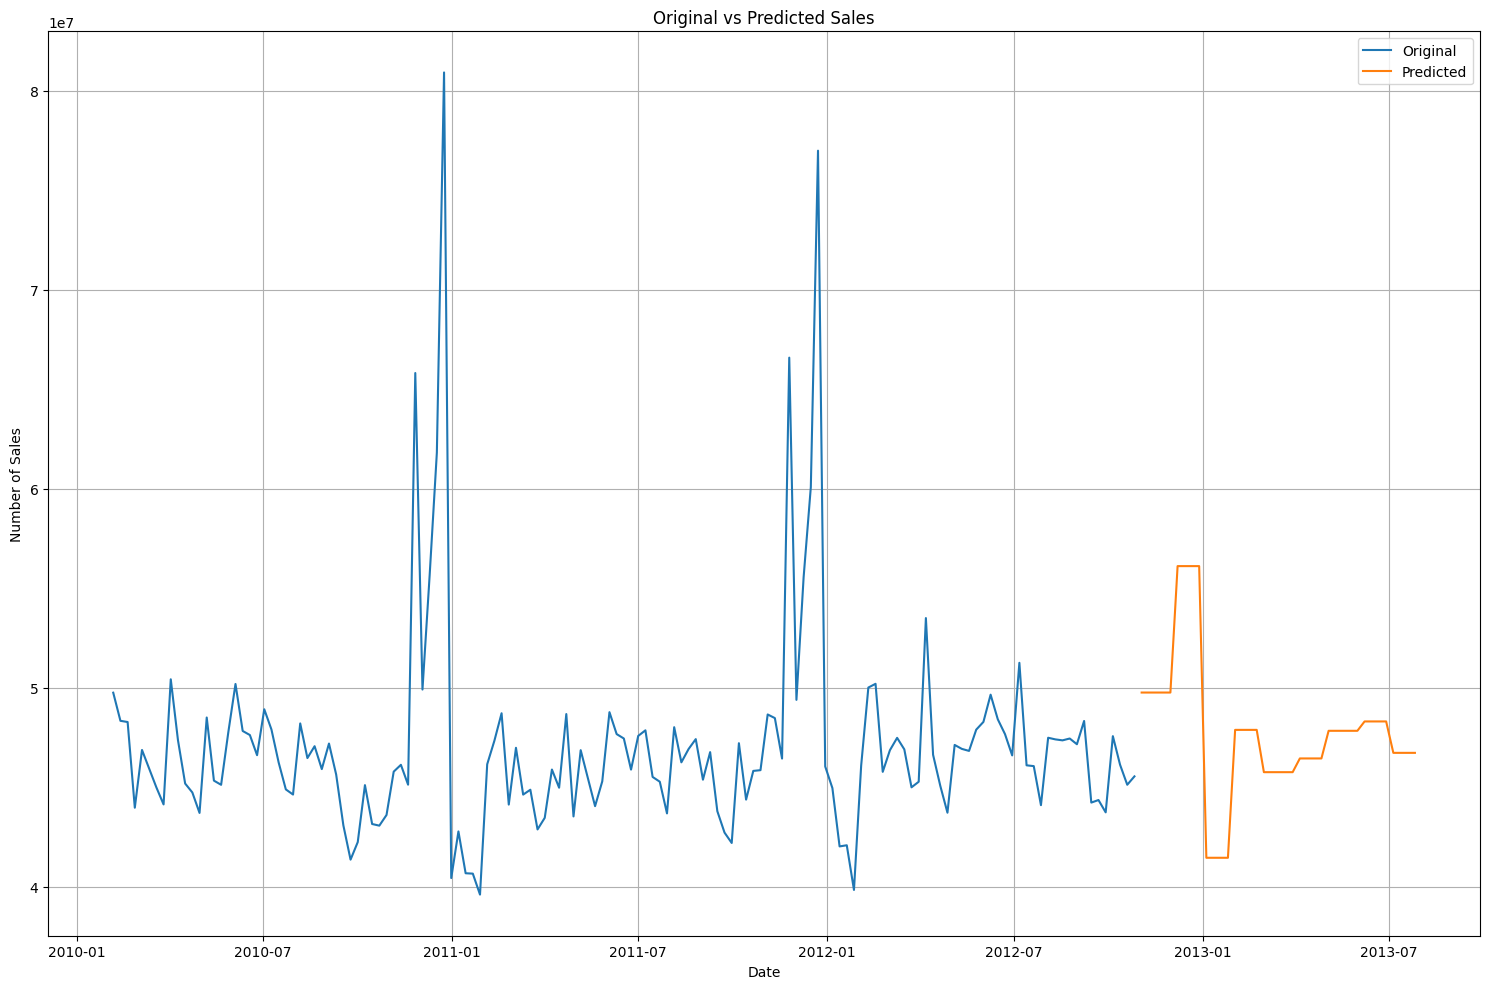

In [13]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=train_agg, x="Date", y="Weekly_Sales", label='Original')
sns.lineplot(data=test_dates, x="Date", y="Weekly_Sales", label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.title('Original vs Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

In [15]:
product_df = train.groupby(["Date","Dept"])["Weekly_Sales"].sum().reset_index()
product_ratio_df = product_df.pivot(index="Date", columns="Dept", values="Weekly_Sales")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df

,Date,Dept,ratios
0,2010-02-05,1,1.772503e-02
1,2010-02-05,2,4.015683e-02
2,2010-02-05,3,9.735913e-03
3,2010-02-05,4,2.423686e-02
4,2010-02-05,5,2.245097e-02
...,...,...,...
11085,2012-10-26,95,6.592767e-02
11086,2012-10-26,96,1.216488e-02
11087,2012-10-26,97,1.309859e-02
11088,2012-10-26,98,6.641237e-03


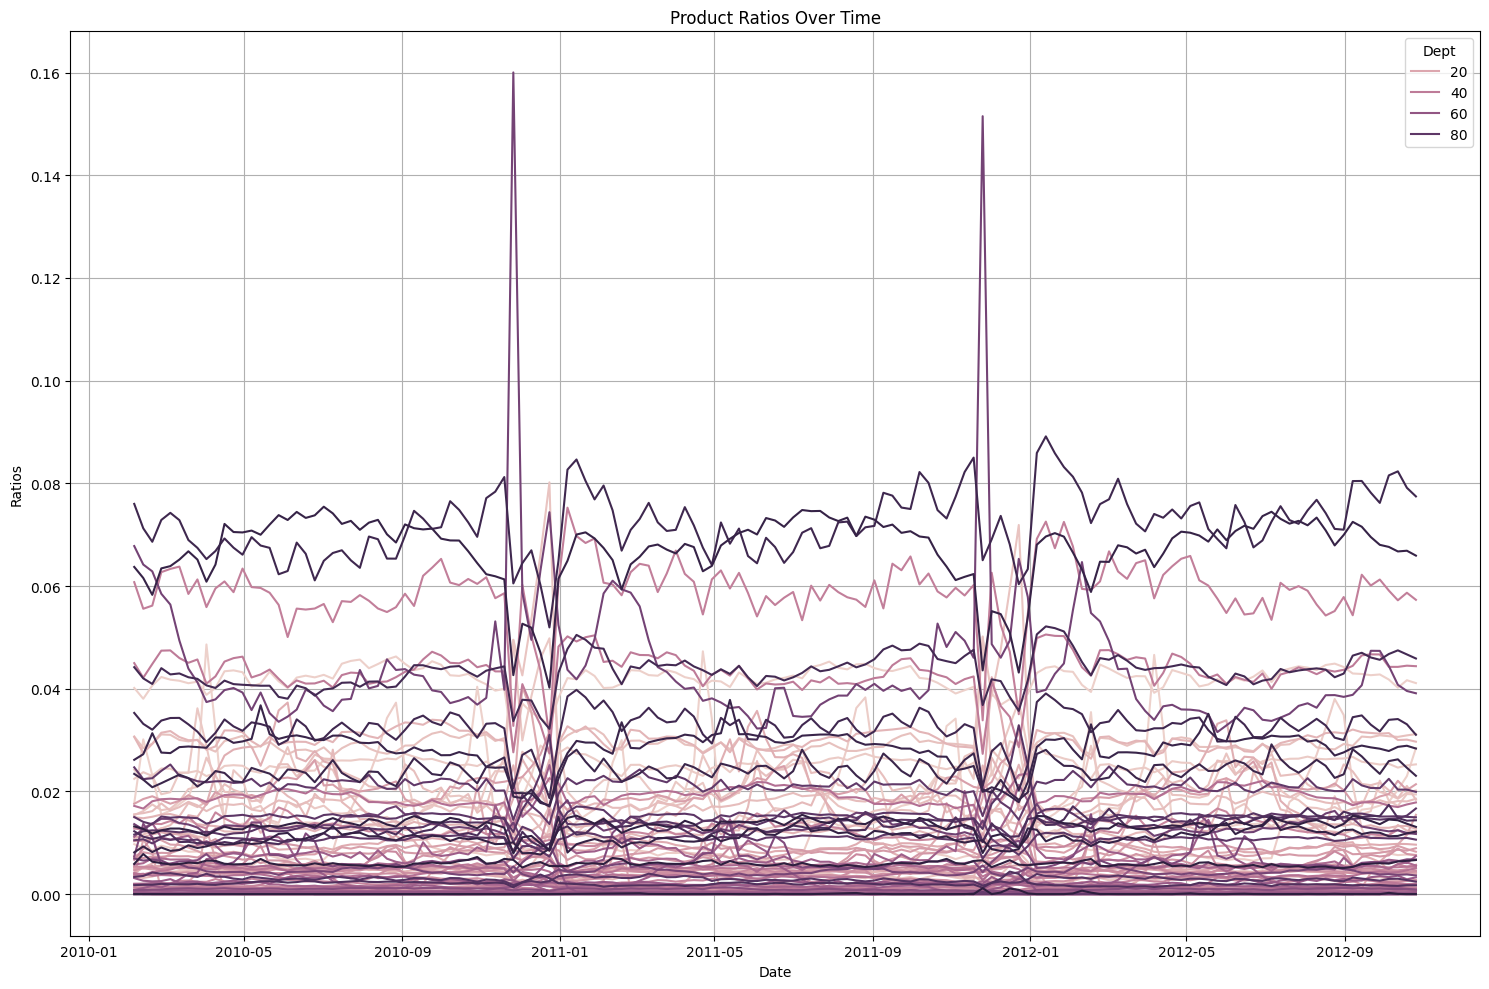

In [16]:
temp_df = pd.concat([product_ratio_df, test_agg]).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.lineplot(data=temp_df, x="Date", y="ratios", hue="Dept")
plt.xlabel("Date")
plt.ylabel("Ratios")
plt.title("Product Ratios Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
test_data = pd.merge(test, test_dates, how='left')
test_data

,Store,Dept,Date,IsHoliday,Year,Month,DayOfWeek,Weekly_Sales
0,1,1,2012-11-02,False,2012,11,4,4.975823e+07
1,1,1,2012-11-09,False,2012,11,4,4.975823e+07
2,1,1,2012-11-16,False,2012,11,4,4.975823e+07
3,1,1,2012-11-23,True,2012,11,4,4.975823e+07
4,1,1,2012-11-30,False,2012,11,4,4.975823e+07
...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,2013,6,4,4.830540e+07
115060,45,98,2013-07-05,False,2013,7,4,4.672630e+07
115061,45,98,2013-07-12,False,2013,7,4,4.672630e+07
115062,45,98,2013-07-19,False,2013,7,4,4.672630e+07


In [18]:
def disagregate_forecast(df, original_data):
    new_df = df.copy()
    total_weekly_sales = original_data['Weekly_Sales'].sum()
    stores_weights = original_data.groupby('Store')['Weekly_Sales'].sum()/total_weekly_sales
    unique_dept = df['Dept'].unique()
    dept_weights = pd.Series(index=unique_dept, data=1/len(unique_dept))
    for dept in dept_weights.index:
        new_df.loc[new_df['Dept'] == dept, 'Weekly_Sales'] *= dept_weights[dept]
    for store in stores_weights.index:
        new_df.loc[new_df['Store'] == store, 'Weekly_Sales'] *= stores_weights[store]
    return new_df

In [19]:
final_df = disagregate_forecast(test_data, train)
final_df

,Store,Dept,Date,IsHoliday,Year,Month,DayOfWeek,Weekly_Sales
0,1,1,2012-11-02,False,2012,11,4,20278.670079
1,1,1,2012-11-09,False,2012,11,4,20278.670079
2,1,1,2012-11-16,False,2012,11,4,20278.670079
3,1,1,2012-11-23,True,2012,11,4,20278.670079
4,1,1,2012-11-30,False,2012,11,4,20278.670079
...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,2013,6,4,9948.973804
115060,45,98,2013-07-05,False,2013,7,4,9623.743077
115061,45,98,2013-07-12,False,2013,7,4,9623.743077
115062,45,98,2013-07-19,False,2013,7,4,9623.743077


In [21]:
sample_submission['Weekly_Sales'] = final_df['Weekly_Sales']
sample_submission.to_csv('submission.csv', index=False)